In [1]:
import numpy

import constants
import rscha2d
import trig
import fibonacci_sphere
import coords

from matplotlib import pyplot

%matplotlib nbagg

In [2]:
lat_c = 42.0
lon_c = 20.0
theta_c, phi_c, theta_0d, theta_0 = numpy.deg2rad((90-lat_c, lon_c, 26.0, 50.0))
# knots_bd = numpy.arange(-900, 2000, 100)
knots = numpy.arange(-2000, 2000, 50)
knots_bd = numpy.arange(-2000, 2000, 50)

In [3]:
theta_m, phi_m = fibonacci_sphere.grid(5000)
in_cap = trig.angulardist(theta_m, phi_m, theta_c, phi_c) < theta_0d
theta_m = theta_m[in_cap]; phi_m = phi_m[in_cap]

# theta_m, phi_m = model.theta_geo, model.phi_geo
r_m = numpy.ones_like(theta_m)*constants.a_r
times_dbd, r_dbd, theta_dbd, phi_dbd = coords.anything(r_m, theta_m, phi_m, knots_bd)
times_d, r_d, theta_d, phi_d = coords.anything(r_m, theta_m, phi_m, knots)

In [28]:
import importlib
importlib.reload(rscha2d)

model_bd = rscha2d.Model()
model_bd.set_model_params(theta_c, phi_c, theta_0d, 0.1, 3, 3, 2, knots=knots_bd,
                          #temporal_reg=3e-2, spatial_reg=0.8, g10_ref=-35)
                          temporal_reg=.5, spatial_reg=1e-1, g10_ref=-35)
model_bd.add_data("../data/rscha2d/bd_sai_trim.dat")

In [29]:
g_bd = model_bd.solve()

In [30]:
D_rem_bd, I_rem_bd, F_rem_bd = model_bd.synth_data(model_bd.tv, model_bd.r_geo,
                                                   model_bd.theta_geo, model_bd.phi_geo, g_bd)
D_rem_bd = trig.mindiff(D_rem_bd, 0)
I_rem_bd = trig.mindiff(I_rem_bd, 0)

D_res_bd = trig.mindiff(D_rem_bd, model_bd.D_o)[~model_bd.nan_D]

I_res_bd = trig.mindiff(I_rem_bd, model_bd.I_o)[~model_bd.nan_I]
F_res_bd = (F_rem_bd - model_bd.F_o)[~model_bd.nan_F]

In [31]:
out_D = (numpy.abs(trig.mindiff(D_rem_bd, model_bd.D_o)) > 3*numpy.std(D_res_bd))
out_I = (numpy.abs(trig.mindiff(I_rem_bd, model_bd.I_o)) > 3*numpy.std(I_res_bd))
out_F = (numpy.abs(F_rem_bd - model_bd.F_o) > 3*numpy.std(F_res_bd))

inliers = ~(out_D | out_I | out_F)
print(f"{(out_D | out_I | out_F).sum()} data sent straight to the gulag")

93 data sent straight to the gulag


In [32]:
with open("../data/rscha2d/bd_sai_trim_fil.dat", "w") as f:
    for i, line in enumerate(open("../data/rscha2d/bd_sai_trim.dat", "r")):
        if i in model_bd.ids[inliers]:
            f.write(line)
            
model_bd.add_data("../data/rscha2d/bd_sai_trim_fil.dat")

In [33]:
g_bd = model_bd.solve()

In [34]:
D_rem_bd, I_rem_bd, F_rem_bd = model_bd.synth_data(model_bd.tv, model_bd.r_geo,
                                                   model_bd.theta_geo, model_bd.phi_geo, g_bd)
D_rem_bd = trig.mindiff(D_rem_bd, 0)
I_rem_bd = trig.mindiff(I_rem_bd, 0)

D_res_bd = trig.mindiff(D_rem_bd, model_bd.D_o)[~model_bd.nan_D]

I_res_bd = trig.mindiff(I_rem_bd, model_bd.I_o)[~model_bd.nan_I]
F_res_bd = (F_rem_bd - model_bd.F_o)[~model_bd.nan_F]

<IPython.core.display.Javascript object>


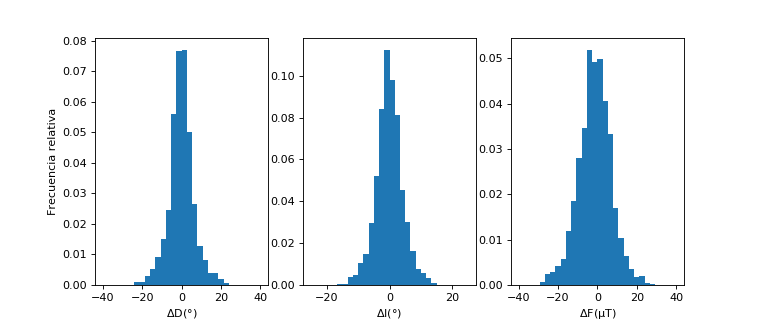

In [35]:
fig, axes = pyplot.subplots(nrows=1, ncols=3, figsize=(9.5, 4))

axes[0].hist(numpy.rad2deg(D_res_bd), color="C0",
             label="residuos (bd)", range=(-40, 40), normed=True, bins=30)
axes[0].set_xlabel("$\Delta $D(°)")

axes[1].hist(numpy.rad2deg(I_res_bd), color="C0",
             label="residuos (bd)", range=(-25, 25), normed=True, bins=30)
axes[1].set_xlabel("$\Delta $I(°)")

axes[2].hist(F_res_bd, color="C0",
             label="residuos (bd)", range=(-40, 40), normed=True, bins=30)
axes[2].set_xlabel("$\Delta $F(μT)")

axes[0].set_ylabel("Frecuencia relativa")

pyplot.show(fig)
#fig.savefig("../data/rscha2d/distribucion.png", frameon=True)

In [36]:
t_cur = numpy.linspace(-2000, 2000, 400)
name_at = "Madrid"
theta_at, phi_at = numpy.deg2rad((90 - 40.423, -3.7))

t_cur, r_cur, theta_cur, phi_cur = coords.curve_at(t_cur, constants.a_r, theta_at, phi_at)
D_cur_bd, I_cur_bd, F_cur_bd = model_bd.synth_data(t_cur, r_cur, theta_cur, phi_cur, g_bd)
D_cur_bd = trig.mindiff(D_cur_bd, 0)
I_cur_bd = trig.mindiff(I_cur_bd, 0)

In [37]:
import geofield
import xyzfield

sha = geofield.SHADIFData("../data/sha.dif.14k/coeff_SHA.DIF.14k.dat",
                          "../data/sha.dif.14k/error_coef_EPSL_tnmgh.dat")

D_shadif = numpy.empty_like(sha.years)
I_shadif = numpy.empty_like(sha.years)
F_shadif = numpy.empty_like(sha.years)

years = numpy.array(sha.years)

for i, y in enumerate(sha.years):
    dec,inc,f,h = xyzfield.xyz2difh(*xyzfield.xyzfieldv2(sha.gcomp[i, :],
                                                         numpy.atleast_1d(phi_at),
                                                         numpy.atleast_1d(theta_at)))
    D_shadif[i] = dec
    I_shadif[i] = inc
    F_shadif[i] = f
    
D_shadif, I_shadif = numpy.rad2deg((D_shadif, I_shadif))

<IPython.core.display.Javascript object>


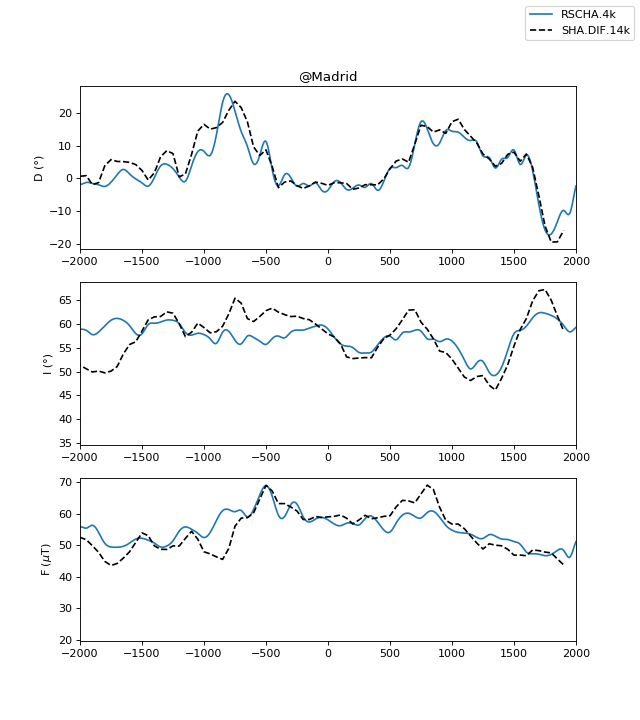

In [38]:
fig, (ax0, ax1, ax2) = pyplot.subplots(3,1, figsize=(8,9))

ax0.plot(t_cur, numpy.rad2deg(D_cur_bd), label="RSCHA.4k")
ax0.plot(years, D_shadif, "k--", label="SHA.DIF.14k")
ax0.set_ylabel("D (°)")
ax1.plot(t_cur, numpy.rad2deg(I_cur_bd))
ax1.plot(years, I_shadif, "k--")
ax1.set_ylabel("I (°)")
ax2.plot(t_cur, F_cur_bd)
ax2.plot(years, F_shadif, "k--")
ax2.set_ylabel("F ($\mu $T)")

ax0.set_title("@{}".format(name_at))

for ax in (ax0, ax1, ax2):
    ax.set_xbound(-2000, 2000)
    
fig.legend(*ax0.get_legend_handles_labels())

<IPython.core.display.Javascript object>


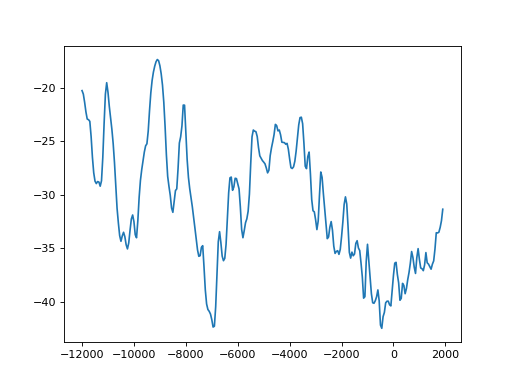

In [39]:
fig, ax = pyplot.subplots()
ax.plot(sha.years, sha.gcomp[:, 0])
pyplot.show(fig)